# Explore ET cells

This notebook presents a quick overview on how to access the underlying enclosed tessellation (ET) cells that are used to build the signatures. More information on how these units are created and used to delineate the final boundaries is available in the [Urban Grammar story](https://urbangrammarai.xyz/story/).

## Understanding the structure of the dataset

The dataset amounts, in total, to about 50GB. However, it is divided in many smaller parts (or chunks) that refer to areas broadly grouped geographically. The files are also divided in two sets, one for form (which includes the geometries of each ET cell polygon) and one for function. Both can be linked easily through a unique ID key present in both tables.

In [1]:
import pandas
import geopandas
import contextily
from xyzservices import providers
from shapely.geometry import Point
from tqdm import tqdm
import fsspec

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Querying data locally

If you have a full copy on your local hardrive, we recommend using [`dask_geopandas`](https://github.com/geopandas/dask-geopandas). We include below an illustration (from [here](https://github.com/urbangrammarai/signatures_gb#use)) with snippets that are hard-coded rather than meant to be interactively run.

The dataset can be approached as a [`dask_geopandas.GeoDataFrame`](https://dask-geopandas.readthedocs.io/en/stable/docs/reference/geodataframe.html) object. To connect to the data:

1. Clone the repository:

```shell
> git clone https://github.com/urbangrammarai/signatures_gb.git
```

2. Fire up a Python session on an environment where [`dask-geopandas`](https://dask-geopandas.readthedocs.io/en/stable/index.html) is installed (for example, the ['gds_env'](https://darribas.org/gds_env/)), and import it to the session:

```python
import dask_geopandas
```

3. Connect to the required table (e.g., form):

```python
db = dask_geopandas.read_parquet('form')
```

4. The above should give you access to the table:

```python
>>> db.info()
<class 'dask_geopandas.core.GeoDataFrame'>
Columns: 238 entries, hindex to area-weighted ETCs of enclosure (Q3)
dtypes: geometry(1), object(1), float64(234), int64(2)

>>>  db.head()
             hindex  ... area-weighted ETCs of enclosure (Q3)
0  c000e109777t0000  ...                             0.001069
1  c000e109777t0001  ...                             0.001024
2  c000e109777t0002  ...                             0.001024
3  c000e109777t0003  ...                             0.001064
4  c000e109777t0004  ...                             0.000928

[5 rows x 238 columns]
```

## Querying data online

If you don't have a local copy and only need a small section of the overall dataset, you can take advantage of the fact that each table is split into 1,000 chunks that cover smaller areas. This is slightly more involved and requires a bit more computation, but is also more efficient storage-wise on the client side (so great for demos!).

You can see the bounding box of each chunk on a "joiner" file we provide at:

In [2]:
bboxes_url = (
    "https://github.com/urbangrammarai/signatures_gb/"
    "raw/main/tools/chunks.geojson"
)

This file can be read directly over the wire:

In [3]:
bboxes = geopandas.read_file(bboxes_url)

With this, and a bit of standard GIS operations, we can query arbitrary parts of the data. The general strategy we will follow to obtain these data is:

1. Find coordinates of interest
2. Build buffer around them
3. Convert to the OSGB national grid (`EPSG:27700`), the CRS used in our dataset
4. Query which chunks are required
5. Read sections of the relevant chunks within the area of interest

For this illustration, we want to pull out data for a buffer of 1Km around the famous [Anfield stadium](https://en.wikipedia.org/wiki/Anfield) in Liverpool, for which we have retrieved the coordinates manually:

In [4]:
anfield_coords = (-2.96159, 53.43083)

From the `anfield` object, we can pull out the coordinates and we can save them as a `GeoSeries` from which we draw the buffer:

<AxesSubplot:>

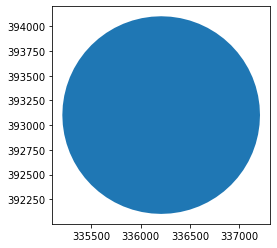

In [5]:
buff = (
    geopandas.GeoSeries([Point(*anfield_coords)])
    .set_crs(epsg=4327)
    .to_crs(epsg=27700)
    .centroid
    .buffer(1000)
)
buff.plot()

With `buff`, we can go to `bboxes` to see which files we will need:

In [6]:
intersecting_chunk_files = geopandas.sjoin(
    geopandas.GeoDataFrame({'geometry': buff}), 
    bboxes.to_crs(buff.crs), 
    how='left'
)['file'].tolist()

intersecting_chunk_files

['part.593.parquet',
 'part.462.parquet',
 'part.467.parquet',
 'part.463.parquet',
 'part.464.parquet',
 'part.465.parquet']

Now we can write a small function that takes one of these files (and the buffer) and returns the `GeoDataFrame` with ET cells _within_ the buffer of interest:

In [7]:
def process_file(p, geom):
    with fsspec.open(p) as file:
        tmp = geopandas.read_parquet(file)
    return tmp.clip(geom.to_crs(tmp.crs))

All the files are hosted on Github and we can use a similar URL to access them as the `bboxes` object. So we now write another small function to read all the potentially relevant files and merge them into a single one:

In [8]:
def process_files(ps, geom):
    parts = []
    for p in tqdm(ps):
        parts.append(process_file(p, geom))
    return pandas.concat(parts)

And run it sequentially:

In [9]:
%%time
base_url = 'https://github.com/urbangrammarai/signatures_gb/raw/main/form/'
out = process_files(
    [base_url+p for p in intersecting_chunk_files], buff
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:08<00:00,  1.44s/it]

CPU times: user 1.96 s, sys: 931 ms, total: 2.89 s
Wall time: 8.63 s


And voila! here's the set of ET cells within 1Km of Anfield:

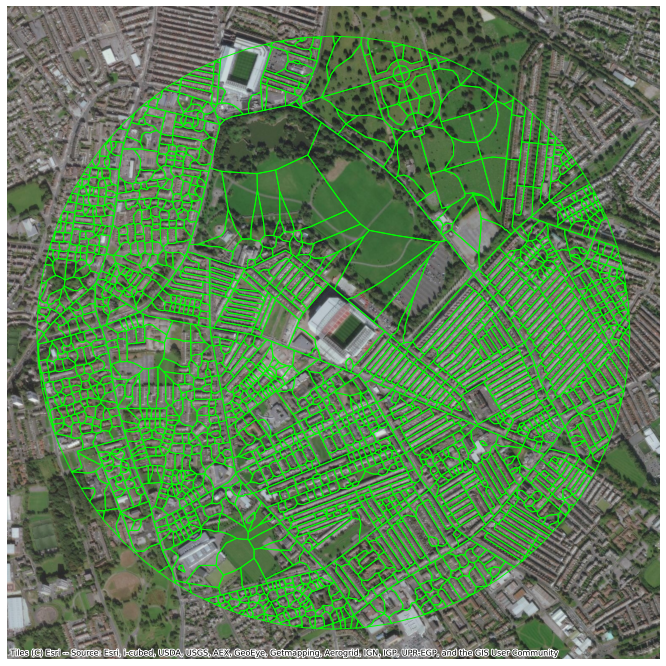

In [10]:
ax = out.plot(
    facecolor='none', edgecolor='#00FF00', figsize=(12, 12)
)
contextily.add_basemap(
    ax,
    crs=out.crs,
    source=providers.Esri.WorldImagery
)
ax.set_axis_off();